# 5-ый этап

## 5.1 Импорт библиотек и данных

In [ ]:
!pip install bitsandbytes
!pip install sentence_transformers
!pip install pydrive
!pip install gdown
!pip install rank_bm25
!pip install langchain
!pip install wget
!pip install bert_score
!pip install faiss-gpu

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import gdown
import random
import time
import re

from transformers import BertTokenizer, BertModel
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores.faiss import FAISS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from rank_bm25 import BM25Okapi
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
from langchain.prompts import PromptTemplate
from langchain.vectorstores.faiss import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import EnsembleRetriever, BM25Retriever
from typing import List, Coroutine, Any
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

import warnings
warnings.filterwarnings("ignore")

2024-05-15 16:17:21.849722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 16:17:21.849855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 16:17:22.023825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from IPython.display import Image
import requests

In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=1fCvwaS-u4MtSo8z_vqzsfJGc8D9_ZEn0"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="df_knowledge_base_4.2.xlsx")

# Чтение данных из Excel файла в датафрейм
df_knowledge_base = pd.read_excel("df_knowledge_base_4.2.xlsx")

Downloading...
From: https://drive.google.com/uc?id=1fCvwaS-u4MtSo8z_vqzsfJGc8D9_ZEn0
To: /kaggle/working/df_knowledge_base_4.2.xlsx
100%|██████████| 394k/394k [00:00<00:00, 95.6MB/s]


In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=136c244E3ihfmAu3znJvEPR9WngEXl5Om"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="df_QA_pairs_3.2.xlsx")

# Чтение данных из Excel файла в датафрейм
df_QA_pairs = pd.read_excel("df_QA_pairs_3.2.xlsx")

Downloading...
From: https://drive.google.com/uc?id=136c244E3ihfmAu3znJvEPR9WngEXl5Om
To: /kaggle/working/df_QA_pairs_3.2.xlsx
100%|██████████| 1.59M/1.59M [00:00<00:00, 103MB/s]


Downloading...
From: https://drive.google.com/uc?id=1_RQFWzawp1kp-Uy2075eRaJ6ZB-XtCbs
To: /kaggle/working/Structure_RAG.jpg
100%|██████████| 334k/334k [00:00<00:00, 97.2MB/s]


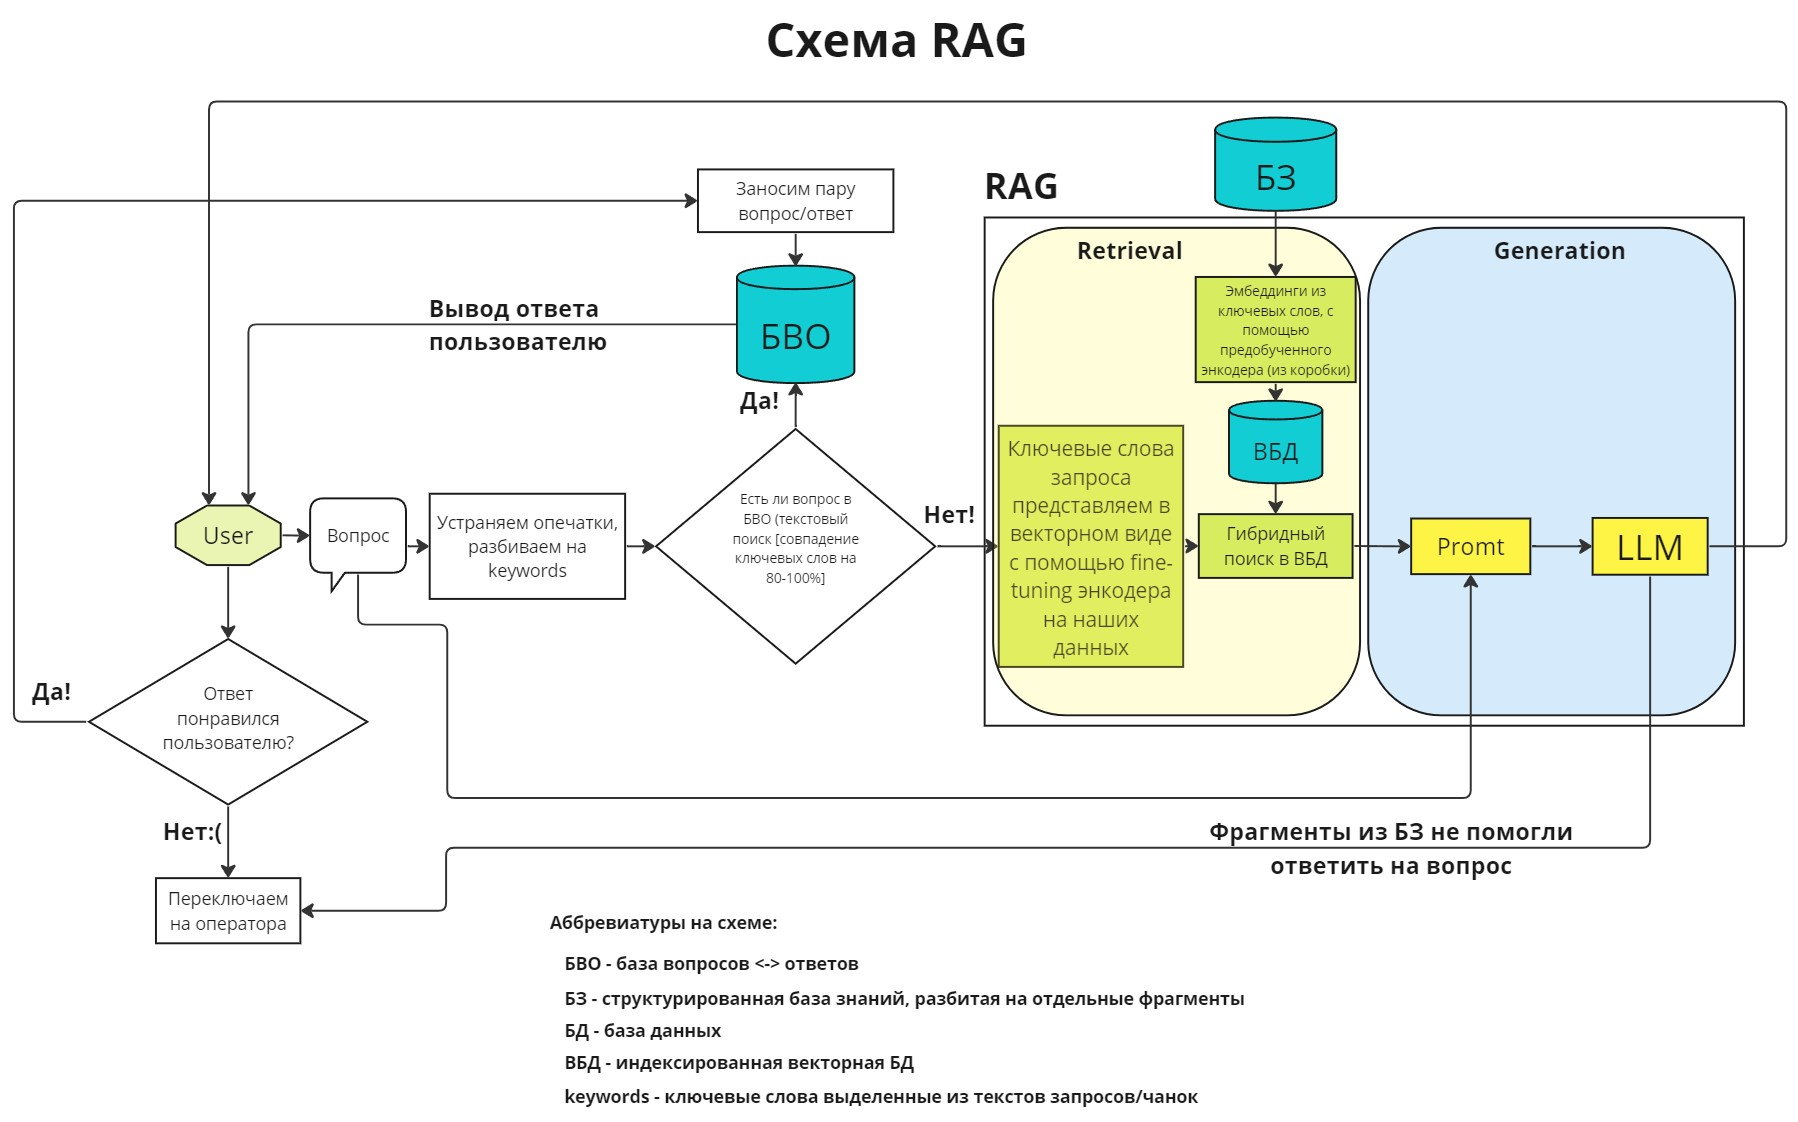

In [ ]:
gdown.download('https://drive.google.com/uc?id=1_RQFWzawp1kp-Uy2075eRaJ6ZB-XtCbs', output="Structure_RAG.jpg")
Image(filename='/kaggle/working/Structure_RAG.jpg')

## 5.2. Реализация модуля retrieval

In [ ]:
class HuggingFaceEmbeddings(HuggingFaceEmbeddings):
    def embed_query(self, text: str) -> List[float]:
        text = f'query: {text}'
        return super().embed_query(text)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        texts = [f'passage: {text}' for text in texts]
        return super().embed_documents(texts)

    async def aembed_query(self, text: str) -> Coroutine[Any, Any, List[float]]:
        text = f'query: {text}'
        return await super().aembed_query(text)

    async def aembed_documents(self, texts: List[str]) -> Coroutine[Any, Any, List[List[float]]]:
        texts = [f'passage: {text}' for text in texts]
        return await super().aembed_documents(texts)

In [ ]:
embedding_e5 = HuggingFaceEmbeddings(model_name='intfloat/multilingual-e5-large')
# Инициализируем векторную БД
text_chunk = df_knowledge_base['chunk'].tolist()
faiss_vectorbase_e5=FAISS.from_texts(text_chunk, embedding_e5)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [ ]:
bm25 = BM25Retriever.from_texts(text_chunk)
bm25.k = 1
faiss_retriever_e5 = faiss_vectorbase_e5.as_retriever(search_kwargs={'k': 1})

In [ ]:
ensemble_retriever = EnsembleRetriever(retrievers=[bm25, faiss_retriever_e5], weidgts=[0.2, 0.8])

### Итоги:

Была создана векторная база данных и выбран в качестве ретривера - гибридный поиск на основе bm25 (текстовый поиск) и e5 (векторного поиска в векторной базе данных faiss).

## 5.3. Рeализация модуля generation

In [ ]:
llm_openchat = 'openchat/openchat-3.5-0106'
tokenizer_openchat = AutoTokenizer.from_pretrained(llm_openchat)
model_openchat = AutoModelForCausalLM.from_pretrained(llm_openchat,
                                                     device_map='auto',
                                                     load_in_8bit=True)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

In [ ]:
pipe_openchat = pipeline('text-generation',
                model=model_openchat,
                tokenizer=tokenizer_openchat)

In [ ]:
%%time
# Проверим работу на единичном запросе
question = 'Какая минимальная площадь помещения?'
s = 'Фрагменты базы знаний:\n'
for i in range(len(ensemble_retriever.invoke(question))):
    s += ensemble_retriever.invoke(question)[i].page_content
    s += '\n'
content = """Ты – сотрудник техподдержки Вайлдберриз. Начинай свой ответ с слова «Здравствуйте!» \
Ниже приведены фрагменты базы знаний и запрос пользователя. Ответь на вопрос пользователя используя информацию из фрагментов ниже.\
Если в фрагментах ниже не будет ответа скажи: «Я не знаю ответ, пожалуйста сформулируйте свой вопрос иначе».""" + s
print(pipe_openchat([{'role': 'system',
               'content': content},
              {'role': 'user', 'content': question}],
             max_new_tokens=512,
             do_sample=True,
             temperature=0.8)[0]['generated_text'][-1]['content'])

 Здравствуйте! Минимальная площадь помещения ПВЗ в городах миллионниках и населённых пунктах Московской области должна быть не менее 70 квадратных метров, в остальных городах - не менее 50 квадратных метров. Если Вам нужна информация о Складской зоне ПВЗ, то в любом случае минимальная площадь должна быть не менее 30 квадратных метров.
CPU times: user 42.6 s, sys: 23.5 ms, total: 42.6 s
Wall time: 42.6 s


In [ ]:
def get_answer_openchat(question, max_new_tokens=2048, temperature=0.7):
    """Функция для генерации ответом с помощью LLM openchat-3.5"""
    s = 'Фрагменты базы знаний:\n'
    for i in range(len(ensemble_retriever.invoke(question))):
        s += ensemble_retriever.invoke(question)[i].page_content
        s += '\n'
    content = """Ты – сотрудник техподдержки Вайлдберриз. Начинай свой ответ с слова «Здравствуйте!» \
    Ниже приведены фрагменты базы знаний и запрос пользователя. Ответь на вопрос пользователя используя информацию из фрагментов ниже.\
    Если в фрагментах ниже не будет ответа скажи: «Я не знаю ответ, пожалуйста сформулируйте свой вопрос иначе».""" + s
    return pipe_openchat([{'role': 'system',
               'content': content},
              {'role': 'user', 'content': question}],
             max_new_tokens=max_new_tokens,
             do_sample=True,
             temperature=temperature)[0]['generated_text'][-1]['content'][1:]

In [ ]:
%%time
random.seed(2)
questions = []
for _ in range(100):
    questions.append(random.choice(df_QA_pairs['question'].values))
print(*questions, sep='\n')

Как посмотреть номер телефона в приложении?
Что если товар добавлен в 2 возвратные коробки?
Что делать если не закрыл возвратную коробку?
Могу ли я принять обувь без упаковочной коробки?
Что за вес показывается в рейтинге?
Если вскрыта заводская упаковка
Товар сам ушёл на полку
У Клиента пришла посылка не та которую заказали
Добавить пакт
Как сгенерировать ШК?
Как прикрепить видео о зависшем ШК?
В какой срок юридически значимые сообщения считаются доставленными через электронную почту?
Как пробить пакет, если закрыл страницу клиента?
Приемка с одного аккаунта
Субсидия при открытии ПВЗ
Что будет, если наполнить возвратную коробку больше чем на 10 тысяч?
Отправить сообщение в Вайлдберриз
Как стать официальным пунктом?
как быть с излишками при переупаковки ?
Какие товары отмечать бракованными?
Косметика в сейф-пакете. Можно ли отказаться?
Какой товар попадает в статистику моей работы и другие данные?
Информация предоставлена корректно. Смена юридического лица, номер остается прежним
Где в

In [ ]:
questions = questions[:20]
questions

['Как посмотреть номер телефона в приложении?',
 'Что если товар добавлен в 2 возвратные коробки?',
 'Что делать если не закрыл возвратную коробку?',
 'Могу ли я принять обувь без упаковочной коробки?',
 'Что за вес показывается в рейтинге?',
 'Если вскрыта заводская упаковка',
 'Товар сам ушёл на полку',
 'У Клиента пришла посылка не та которую заказали',
 'Добавить пакт',
 'Как сгенерировать ШК?',
 'Как прикрепить видео о зависшем ШК?',
 'В какой срок юридически значимые сообщения считаются доставленными через электронную почту?',
 'Как пробить пакет, если закрыл страницу клиента?',
 'Приемка с одного аккаунта',
 'Субсидия при открытии ПВЗ',
 'Что будет, если наполнить возвратную коробку больше чем на 10 тысяч?',
 'Отправить сообщение в Вайлдберриз',
 'Как стать официальным пунктом?',
 'как быть с излишками при переупаковки ?',
 'Какие товары отмечать бракованными?']

In [ ]:
import logging
import transformers

# Отключение логирования для transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

In [ ]:
from bert_score import score as bert_score
import time

In [ ]:
# Список для хранения времени генерации ответов
generation_times = []
# Генерация ответов и измерение времени
generated_answers = []
for question in questions:
    start_time = time.time()
    generated_answer = get_answer_openchat(question)
    end_time = time.time()
    generation_time = end_time - start_time
    generated_answers.append(generated_answer)
    generation_times.append(generation_time)
# Формирование списка экспертных ответов
expert_answers = [df_QA_pairs[df_QA_pairs['question'] == question]['answer'].iloc[0] for question in questions]

In [ ]:
# Обновленная функция quality_score_llm для учета времени генерации
def quality_score_llm_2(questions, generated_answers, expert_answers, generation_times):
    results = []
    for question, generated_answer, expert_answer, generation_time in zip(questions, generated_answers, expert_answers, generation_times):
        precision, recall, f1 = bert_score([generated_answer], [expert_answer], lang="ru")

        # Получаем средние значения для precision, recall и f1
        precision_val = precision.mean().item()
        recall_val = recall.mean().item()
        f1_val = f1.mean().item()

        results.append({
            'question': question,
            'answer_gen': generated_answer,
            'answer_exp': expert_answer,
            'precision': round(precision_val, 3),
            'recall': round(recall_val, 3),
            'f1_val': round(f1_val, 3),
            'generation_time': round(generation_time, 2)
        })

    result_df = pd.DataFrame(results)
    return result_df

In [ ]:
df_score_llm_openchat_2 = quality_score_llm_2(questions, generated_answers, expert_answers, generation_times)

In [ ]:
df_score_llm_openchat_2

,question,answer_gen,answer_exp,precision,recall,f1_val,generation_time
0,Как посмотреть номер телефона в приложении?,Здравствуйте!\n\nВнутри приложения номер телеф...,Если вы хотите посмотреть свой номер телефона ...,0.649,0.684,0.666,64.08
1,Что если товар добавлен в 2 возвратные коробки?,Здравствуйте!\n\nЕсли товар добавлен в 2 возвр...,Товар по программе может быть добавлен только ...,0.702,0.786,0.742,24.31
2,Что делать если не закрыл возвратную коробку?,"Здравствуйте! Если вы не закроете коробку, она...","Если коробка не закрыта по программе, а курьер...",0.678,0.682,0.680,12.36
3,Могу ли я принять обувь без упаковочной коробки?,Здравствуйте!\n\nЕсли обувь была доставлена бе...,"При возврате товара без брака, он должен быть ...",0.621,0.656,0.638,50.15
4,Что за вес показывается в рейтинге?,Здравствуйте!\n\nВ рейтинге ПВЗ используется в...,"В разделе ""Рейтинг"" рядом с оценкой от Клиента...",0.635,0.577,0.604,54.01
5,Если вскрыта заводская упаковка,"Здравствуйте! Если вскрыта заводская упаковка,...","Если можно вскрыть заводскую упаковку товара, ...",0.688,0.694,0.691,28.82
6,Товар сам ушёл на полку,Здравствуйте! Согласно информации из базы знан...,"Если выдача не прошла, то отсканируйте код кли...",0.622,0.717,0.666,54.63
7,У Клиента пришла посылка не та которую заказали,Здравствуйте! В таком случае Клиент имеет прав...,Если после вскрытия заводской упаковки обнаруж...,0.696,0.724,0.710,39.32
8,Добавить пакт,Здравствуйте!\n\nДля добавления пакетов к зака...,"При выдаче заказа, нажмите на кнопку «Пакет», ...",0.646,0.719,0.680,77.43
9,Как сгенерировать ШК?,Здравствуйте!\n\nСогласно фрагменту базы знани...,Воспользуйтесь ботом и он сгенерирует ШК,0.591,0.721,0.650,57.30


In [ ]:
# Сохраним df в файл
df_score_llm_openchat_2.to_excel('df_score_llm_openchat_2.xlsx', index=False)

### Итоги:

Для генерации ответов на основе запросов пользователей и информации из базы знаний была загружена и протестирована openchat-3.5 с параметрами, подбранными в 4-ом этапе

## 5.4. Создание базы вопросов-ответов

In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=14cVh-p22ka0hGyOdZ7HF2tGyNDap2IlT"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="func_correct_spelling.ipynb")

Downloading...
From: https://drive.google.com/uc?id=14cVh-p22ka0hGyOdZ7HF2tGyNDap2IlT
To: /kaggle/working/func_correct_spelling.ipynb
100%|██████████| 2.56k/2.56k [00:00<00:00, 4.14MB/s]


'func_correct_spelling.ipynb'

In [ ]:
%run /kaggle/working/func_correct_spelling.ipynb

In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=1iMOskRbKgbBIrSPb8kKqzKHufcRDGZcO"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="df_knowledge_base_doc13.xlsx")

# Чтение данных из Excel файла в датафрейм
df_knowledge_base_doc13 = pd.read_excel("df_knowledge_base_doc13.xlsx")

Downloading...
From: https://drive.google.com/uc?id=1iMOskRbKgbBIrSPb8kKqzKHufcRDGZcO
To: /kaggle/working/df_knowledge_base_doc13.xlsx
100%|██████████| 63.8k/63.8k [00:00<00:00, 46.0MB/s]


In [ ]:
df_BQA = df_knowledge_base_doc13.copy()

In [ ]:
%%time
df_BQA['question'] = df_BQA['question'].apply(correct_spelling)

CPU times: user 5.04 s, sys: 0 ns, total: 5.04 s
Wall time: 2min 49s


In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=1ByP0y3wEZfEaQbC9QtAabuZDWjUw8zVN"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="df_QA_hello_2.1.xlsx")

# Чтение данных из Excel файла в датафрейм
df_QA_hello = pd.read_excel("df_QA_hello_2.1.xlsx")

Downloading...
From: https://drive.google.com/uc?id=1ByP0y3wEZfEaQbC9QtAabuZDWjUw8zVN
To: /kaggle/working/df_QA_hello_2.1.xlsx
100%|██████████| 6.24k/6.24k [00:00<00:00, 9.38MB/s]


In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=1_6k53ZJ0iObcA3dFgpOxYuJ-UPnsiqNM"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="df_QA_bot_2.1.xlsx")

# Чтение данных из Excel файла в датафрейм
df_QA_bot = pd.read_excel("df_QA_bot_2.1.xlsx")

Downloading...
From: https://drive.google.com/uc?id=1_6k53ZJ0iObcA3dFgpOxYuJ-UPnsiqNM
To: /kaggle/working/df_QA_bot_2.1.xlsx
100%|██████████| 5.20k/5.20k [00:00<00:00, 8.57MB/s]


In [ ]:
merged_df = pd.concat([df_QA_hello, df_QA_bot, df_BQA], ignore_index=True)
merged_df.shape

(319, 3)

In [ ]:
global df_BQA, set_question_of_BQA
df_BQA = merged_df.copy()
df_BQA.reset_index(drop=True, inplace=True) # Обновим индексы
set_question_of_BQA = set(df_BQA['question'])
df_BQA.shape

(319, 3)

In [ ]:
# Сохраним df в файл
df_BQA.to_excel('df_BQA.xlsx', index=False)

### Итоги:

Была создана база готовых вопросов ответов, для того чтобы генерировать ответы пользователям сразу, без обращения к RAG системе.

## 5.5 Проверка работы QA-системы

In [ ]:
def QA_system(question: str) -> str:
    """Функция генерации ответов на вопрос"""
    question = correct_spelling(question)
    if question in set_question_of_BQA:
        return df_BQA[df_BQA['question'] == question]['answer'].iloc[0]
    else:
        return get_answer_openchat(question)

In [ ]:
# Возьмем выборку из 10 случайных вопросов из изначального пула вопросов и 10 вопросов из только что сформированной базы вопросов-ответов
random.seed(2)
questions_2 = []
for _ in range(10):
    questions_2.append(random.choice(questions))
    questions_2.append(random.choice(df_BQA['question'].values))
print(*questions_2, sep='\n')

Что если товар добавлен в 2 возвратные коробки?
Как раскладывать товар?
Что делать если не закрыл возвратную коробку?
Что значит загруженность ПВЗ?
Если вскрыта заводская упаковка
Сколько весит 5 звёзд от клиента в рейтинге ПВЗ
Добавить пакт
Инструкция для заказа вывески в подарок для ПВЗ расположенных в регионах
Товар сам ушёл на полку
Инструкция для заказа вывески в подарок для ПВЗ расположенных в регионах
Что если товар добавлен в 2 возвратные коробки?
Ставит оценки бывший сотрудник, удалите
Если вскрыта заводская упаковка
Что значит утилизация на ПВЗ?
Как пробить пакет, если закрыл страницу клиента?
Если на товаре нет опознавательных знаков, но на упаковке есть баркод, то мы такой товар не переупаковываем?
В какой срок юридически значимые сообщения считаются доставленными через электронную почту?
Разница в выплатах при выплате средств
Субсидия при открытии ПВЗ
Перерыв и рабочее время ПВЗ\


In [ ]:
# Визуально посмотрим на генерацию QA-системы
for q in questions_2:
    print(f'Запрос: {q}')
    print()
    start_time = time.time()
    print(QA_system(q))
    end_time = time.time()
    print()
    print(f"Время выполнения запроса: {round((end_time - start_time), 2)} сек")
    print('-'*100)

Запрос: Что если товар добавлен в 2 возвратные коробки?

Здравствуйте!

Если товар добавлен в две возвратные коробки, то это не является правильным. Каждая возвратная коробка должна быть закрыта и отправлена отдельно. В одной коробке должно быть не более 30 товаров. Если у вас есть крупногабаритные товары, их можно поместить в собственную упаковку и на неё наклеить ШК возвратной коробки. Помните, что коробка должна быть закрыта до 48 часов, иначе она закроется автоматически.

Время выполнения запроса: 52.28 сек
----------------------------------------------------------------------------------------------------
Запрос: Как раскладывать товар?

Раскладку товара необходимо проводить во время приемки, так как при сканировании можно ознакомиться с номером ячейки, в которой должен быть товар Выгружать и разбирать товар следует под камерами видеонаблюдения

Время выполнения запроса: 0.59 сек
----------------------------------------------------------------------------------------------------
З

In [ ]:
# URL файла на Google Диске
file_url = "https://drive.google.com/uc?id=1QV-tPNO5hVyN2-RNyoVhCcjtd-jBdIOE"

# Загрузка файла с помощью gdown
gdown.download(file_url, output="df_score_llm_openchat.xlsx")

# Чтение данных из Excel файла в датафрейм
df_score_llm_openchat = pd.read_excel("df_score_llm_openchat.xlsx")

Downloading...
From: https://drive.google.com/uc?id=1QV-tPNO5hVyN2-RNyoVhCcjtd-jBdIOE
To: /kaggle/working/df_score_llm_openchat.xlsx
100%|██████████| 47.8k/47.8k [00:00<00:00, 40.0MB/s]


In [ ]:
# Посмотрим на медианные значения
print(f'F1-score: {round(df_score_llm_openchat_2.f1_val.median(), 3)}')
print(f'Точность: {round(df_score_llm_openchat_2.precision.median(), 3)}')
print(f'Полнота: {round(df_score_llm_openchat_2.recall.median(), 3)}')
print(f'Время ответов: {round(df_score_llm_openchat_2.generation_time.median(), 2)} сек')

F1-score: 0.666
Точность: 0.641
Полнота: 0.698
Время ответов: 55.96 сек


## 5.6. Итоги 5-го этапа:
1. В качестве ретривера был выбран гибридный поиск bm25 - для текстового поиска, e5 -для векторного поиска по векторной БД.
2. Для генерации ответов на сонове запросов пользователей и найденной информации из базы знаний подобрана openchat-3.5. На 20 случайных вопросах была оценена совместная работа модулей поиска и генерации на основе метрик BERTscore.
3. Создана база готовых вопросов ответов, для последующих быстрых ответов, без обращения к RAG системе.
4. Проверена работа QA системы, которая состоит из модулей:
    - устранения опечаток и проверки вопроса на наличие в базе готовых вопросов/ответов;
    - RAG-модуля.

# Итоги работы по этапам:

## Этап 1:
    1. Был проведен визуальный осмотр имеющихся данных, удалены дубли, сформулирован направление предобработки данных их чистка от символов затрудняющих дальнейшую работу.
    2. Были сформулированы гипотезы по улучшению качества данных для более точного формулирования промта для подачи в LLM.
    3. Произведен ряд манипуляций с текстами и структурой чанок их акутальность для LLM.
    4. Для чанок из базы знаний и запросах пользователей из вопросно-ответной БД были выделены ключевые слова и эмбеддинги, позволяющие выполнять в дальнейшем текстовый и векторный поиск соотвественно.
    
## Этап 2:
    1. Было доработано предварительное разбиение текстов запросов и чанок на ключевые слова, что позволило устранить неинформативные слова, которые не вошли в стандартный стоп-лист. В итоге это позволило добиться лучших векторных представлений.
    2. Произведено сравнение основных подходов в поиске-сопоставлении запросов-чанок из БЗ, проанализированы текстовый и векторный поиск с помощью моделей (CountVectorizer и USE).
    3. После проведения сопоставлений запросов/чанок стали понтятны основные направления улучшения предобработки данных.
    
## Этап 3:
    1. Проведена кластеризация запросов пользователей, для того чтобы выявить дисбаланс в темах запросов пользователей и использовать это при дообучении энкодера запросов пользователей.
    2. Попробовал дообучить энкодер (на основе модели ruBERT-tiny2) на стратифицированной обучающей выборке (запросы-ответы).
    3. Удалось загрузить квантованную LLM. Построена цепь простой RAG на основе библиотек langchein и локальной LLM-mistral.
    4. Сформирован pipeline схемs валидации модуля Generation для оценки качества генерации текущей и последующих моделей.
        
## Этап 4:
__Для улучшения качества поиска нужной информации (retriever):__

    1. Была создана векторная база данных на основе фреймворка faiss, а затем произведен предварительный анализ резульаттов поисков векторных ретриверов на основании моделей ruBERT и e5, в ходе которого была выявлена проблема коротких и длинных чанок в БЗ.
    2. Из базы знаний короткие чанки (менее 200 символов) были объединены со следующими чанками для одного документа, а длинные чанки (более 170 слов) были разделены на чанки меньшего размера.
    3. Была сформулирована и проверена гипотеза о том, что bm25 и векторные ретриверы rubert и e5 будут лучше на ключевых словах, нежели на полнотекстовых чанках. Гипотеза не подтвердилась.
    4. На основе визуального анализа и метрики bert_score был выбран в качестве векторного поиска эмбеддер e5.
    5. Сформирован гибридный поиск на основе bm25 и e5.

__Для улучшения качества генерации ответов:__

    6. Протестированы модели llm_rugpt_medium, llm_rugpt_large, openchat-3.5 для различных параметров этих моделей и формулировок промта/организации pipeline.chain. В итоге была выбрана openchat-3.5 за качество генерации.
    7. Для подбора оптимальных параметров openchat-3.5 был проведен grid search с оценкой качества генерации по BERTscore.

__Создана QA-система:__

    8. Для работы с опечатками была написана функция correct_spelling, которая работает гораздо быстрее Yandex_Speller, используемого на 2-м этапе.
    9. Для ответов на частовстречающиеся вопросы и оптимизации затрат ресурсов на работу RAG системы была создана база вопросов ответов (БВО) (датафреймы: "Приветсвия", "I'm bot", "document_id==13")
    10. Протестирована работа QA-системы на случаных вопросах ответах из БВО и изначального датафрейма с вопросами.
    
## Этап 5:
    1. Были доработаны функции генерации ответов и QA-системы, на основе 20 случайных вопросов сформирован датафрейм с вопросами, ответами системы, колонками оценки качества и времени генерации.
    2. Собран проект в PyCharm c отработкой запросов на локальном сервере с помощью FastAPI.
    3. Квантованную версию LLM openchat-3.5 удалось разместить и запустить на локальной видеокарте.